# A better performance indicator for chlamydia control programme effectiveness: the proportion of infections treated, derived from surveillance data

We compare metrics of chlamydia burden and control programme performance, using data for women aged 15-24 years in English local authorities in 2012.

## Data and setup

Begin by reading in data and running some preliminary/setup scripts.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import *

In [2]:
# This script also contains the functions linking observed tests, symptomatic/asymptomatic/toal diagnoses, 
# incidence, prevalence, screening and other model parameters
# Running it takes a little while because of all the symbolic algebra
%run -i test_diag_fun.py

# This script provides a function for calculating the likelihood of categorical data.
%run -i multinomial_pmf.py

# This script samples model parameters from prior distributions, following the method in england.ipynb.
%run -i sample_parameters.py

In [3]:
# a function for plotting median and 95% credible interval, from sampled values

def plt_ppc(ax, xsample, ysample, index, ci, col, alpha=1): 
    # ci is the confidence interval required, as a %
    ax.errorbar(percentile(xsample, 50, index), 
                percentile(ysample, 50, index), 
                xerr=squeeze(
                    array([[percentile(xsample,50, index) - percentile(xsample, (100.-ci)/2, index)], 
                           [percentile(xsample, (100.+ci)/2, index) - percentile(xsample,50, index)]])
            ), 
                yerr=squeeze(
                    array([[percentile(ysample,50, index) - percentile(ysample, (100.-ci)/2, index)], 
                           [percentile(ysample, (100.+ci)/2, index) - percentile(ysample,50, index)]])
            ),
                linestyle = 'None', color = col, alpha=alpha)

In [4]:
# now read in the local testing and diagnosis rates
import pandas as pd
from pandas import *
pd.options.mode.chained_assignment = None  # default='warn'

alldata = pd.read_csv('2012_age_sex_LA.csv')
alldata = alldata[alldata.la != 'Isles of Scilly'] # remove Scilly Isles because of small numbers
alldata.index = range(len(alldata))

# la: Local Authority (Upper Tier)
# gor: Government Office Region
# phec: Public Health England Region
# pher: Public Health England Centre

In [5]:
# now work out deprivation indices

lsoa_dep = pd.read_csv('2010_deprivation_lsoa.csv') # deprivation scores, by LSOA
lsoa_pop = pd.read_csv('2010_deprivation_denoms_lsoa.csv') # population, by LSOA
code_lookup = pd.read_csv('code_equivalents.csv')
district_key = pd.read_csv('LAD12_CTY12_EN_LU.csv')

lsoas = merge(lsoa_dep, lsoa_pop, on='LSOA CODE')
lsoas = merge(lsoas, code_lookup, how='left', left_on='LA CODE', right_on='Former code')
lsoas.index = lsoas['LSOA CODE']

lsoas['product'] = lsoas['Total population: mid 2008 (excluding prisoners)'] * lsoas['IMD SCORE']

lsoas['LAUT'] = nan

for i in lsoas.index:
        
    if lsoas['Current code'][i] in alldata.la_code.tolist(): # if LA can be found in NCSP data using new code
        lsoas['LAUT'][i] = lsoas['Current code'][i]
    elif lsoas['LA CODE'][i] in district_key['LAD12CDO'].tolist(): # if LA can be found in list of districts
        lsoas['LAUT'][i] = district_key['CTY12CD'][district_key['LAD12CDO']==lsoas['LA CODE'][i]].tolist()[0]
    elif lsoas['LA CODE'][i] == '00EM': # special case for Northumberland, because of a boundary change
        lsoas['LAUT'][i] = 'E06000057'
    else:
        print 'Missed', i, lsoas['LA NAME'][i]

las = lsoas.groupby('LAUT').sum()
las['Weighted IMD SCORE'] = las['product'] / las['Total population: mid 2008 (excluding prisoners)']
las['quintile'] = pd.qcut(las['Weighted IMD SCORE'], 5)


Missed E01019077 Isles of Scilly


(The Isles of Scilly are excluded from this analysis because of their small population, and small numbers of tests and diagnoses.)

In [6]:
# NB random state (rs) is set in sample_parameters.py, above.

# set up arrays to store, for each LA: 
test_sample_f = empty([n_sample, len(alldata)])
diag_sample_f = empty([n_sample, len(alldata)])
diag_f_la = empty([n_sample, len(alldata)])

for i in xrange(len(alldata.index)):
            
    # sample for the testing rate, per sexually active 15-24-year-old
    test_sample_f[:,i] = rs.gamma(alldata['tests.female.total'][i],1,size = n_sample)/ \
        rs.binomial(alldata['population.female.15-19'][i] + alldata['population.female.20-24'][i], 
                        p_active_f_16_24, size=n_sample)
    diag_sample_f[:,i] = rs.gamma(alldata['positives.female.total'][i],1,size = n_sample)/ \
        rs.binomial(alldata['population.female.15-19'][i] + alldata['population.female.20-24'][i], 
                        p_active_f_16_24, size=n_sample)

In [7]:
# set up arrays to store, for each LA: 
scr_f_la = empty([n_sample, len(alldata)])
inc_f_la = empty([n_sample, len(alldata)])
prev_f_la = empty([n_sample, len(alldata)])

A_f = empty([n_sample, len(alldata)]) # proportion asymptomatic-infected
S_f = empty([n_sample, len(alldata)]) # proportion symptomatic-infected

for i in xrange(len(alldata.index)):
    
    # keep track of whether stuff is happening
    if fmod(i,10)==0:
        print i, alldata.la[i]
        
    # screening and diagnosis rates
    diag_f_la[:,i] = zeros(n_sample)
    for j in xrange(n_sample):
        # local screening and incidence, given local testing and diagnoses
        [inc_f_la[j,i], scr_f_la[j,i]] = fsolve(lambda x: test_diag_fun(concatenate([
                        x, array([
                                1-p_asymp_f[j], # proportion of incident infections which are symptomatic
                                sc_f[j], # rate of self-clear 
                                att_symp[j],
                                p_true_pos_f[j], 
                                p_false_pos_f[j]
                            ])])) - array([test_sample_f[j,i],diag_sample_f[j,i]]), [0.09, 0.25])
        # local prevalence, calculated from local screening and incidence
        prev_f_la[j,i] = dyn_fun(
            inc_f_la[j,i]*p_asymp_f[j], 
            sc_f[j] + scr_f_la[j,i]*p_true_pos_f[j], 
            inc_f_la[j,i]*(1-p_asymp_f[j]), 
            scr_f_la[j,i]*p_true_pos_f[j] + att_symp[j]*p_true_pos_f[j]
        )
        
        A_f[j,i] = A_fun(inc_f_la[j,i]*p_asymp_f[j], 
                sc_f[j] + scr_f_la[j,i]*p_true_pos_f[j], 
                inc_f_la[j,i]*(1-p_asymp_f[j]), 
                scr_f_la[j,i]*p_true_pos_f[j] + att_symp[j]*p_true_pos_f[j]
            )
        S_f[j,i] = S_fun(inc_f_la[j,i]*p_asymp_f[j], 
                sc_f[j] + scr_f_la[j,i]*p_true_pos_f[j], 
                inc_f_la[j,i]*(1-p_asymp_f[j]), 
                scr_f_la[j,i]*p_true_pos_f[j] + att_symp[j]*p_true_pos_f[j]
            )



0 Barking and Dagenham
10 Greenwich
20 Kingston upon Thames
30 Waltham Forest
40 Derbyshire
50 Peterborough
60 Solihull
70 Halton
80 Lancashire
90 Wigan
100 South Tyneside
110 Leeds
120 Gloucestershire
130 Bournemouth
140 Medway
150 Wokingham


## Comparing metrics

The first plots compare inequalities in six metrics, calculated by local authority and arranged by deprivation quintile.

In [8]:
# get deprivation quintile for each LA

alldata["offset"] = np.nan

for i in las.index:
    
    if str(las.quintile[i]) == '(30.457, 43.446]':
        alldata.offset[where(alldata.la_code == i)[0]] = 0
    elif str(las.quintile[i]) == '(25.409, 30.457]':
        alldata.offset[where(alldata.la_code == i)[0]] = 1
    elif str(las.quintile[i]) == '(20.215, 25.409]':
        alldata.offset[where(alldata.la_code == i)[0]] = 2
    elif str(las.quintile[i]) == '(15.298, 20.215]':
        alldata.offset[where(alldata.la_code == i)[0]] = 3
    elif str(las.quintile[i]) == '(5.445, 15.298]':
        alldata.offset[where(alldata.la_code == i)[0]] = 4
    else:
        print 'no color'

In [9]:
# work out proportion of infections untreated

quantiles_prop_not_treated_f = 1 - percentile(diag_sample_f / (inc_f_la*(1 - prev_f_la)), [50,2.5,97.5], 0)

In [10]:
plt.rc("savefig", dpi=200) # set resolution
import matplotlib.patches as patches

def boxplot_group(ax, data, group1, group2, g2cols):
    
    xpos = 0
    
    for i in [x for x in set(group1) if not(isnan(x))]:
        for j in [x for x in set(group2) if not(isnan(x))]:
    
            ax.boxplot(data[(group1 == i) & (group2 == j)],
                      positions = atleast_1d(xpos),
                      patch_artist = True, 
                      boxprops = {'ec':g2cols[int(j+1)], 'fc':g2cols[int(j+1)]},
                      whiskerprops = {'linestyle':'-','color':'k'},
                      medianprops = {'linestyle':'-','color':'k'},
                      widths = 0.8
                      )
        
            xpos = xpos + 1
            
        xpos = xpos + 1 # extra space between groups

In [11]:
# which is the median-prevalence LA?
mi_f = argsort(array(percentile(prev_f_la, 50, 0)))[len(alldata.index)//2]
prev_med_f = percentile(prev_f_la, 50, 0)[mi_f]


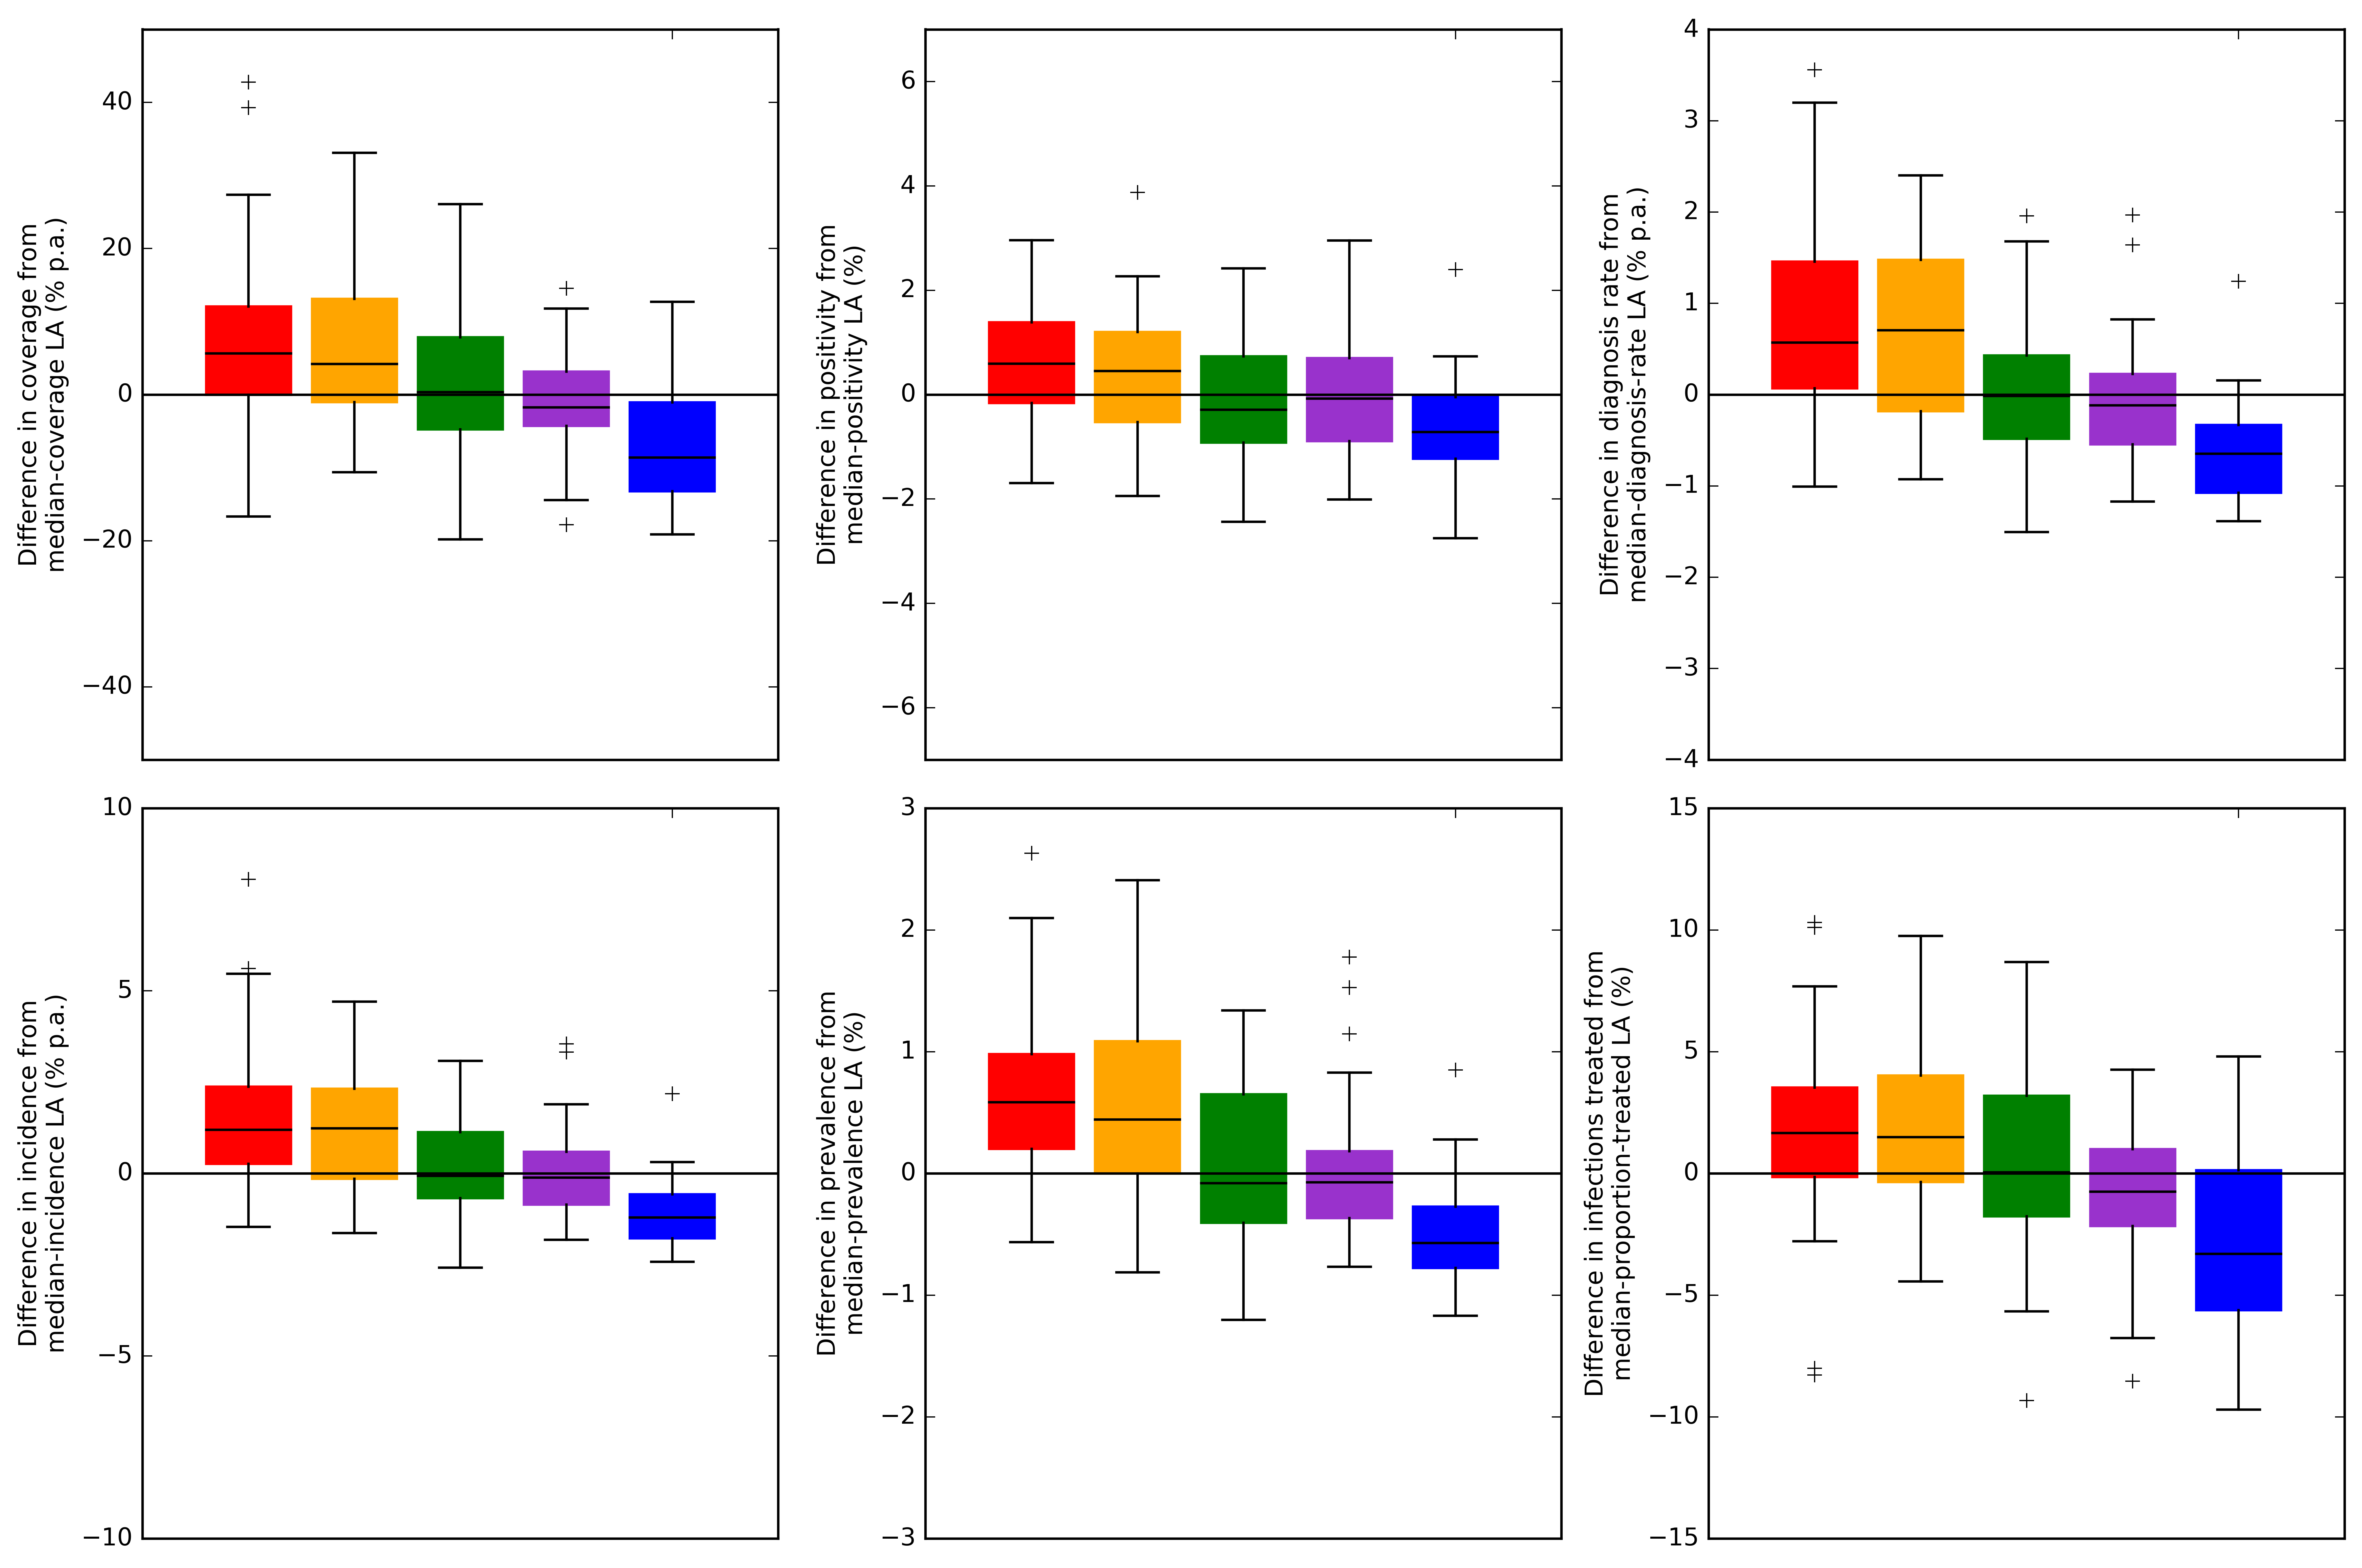

In [12]:
# plot 

plt.rc("savefig", dpi=600) # set resolution
colordict = {0:'None', 1:'r', 2:'orange', 3:'g', 4:'darkorchid', 5:'b'}

fig = plt.figure(figsize = (13.5,9))


###############
# coverage
###############
ax1 = fig.add_subplot(231)
# which is the median-coverage LA?
mi_f = argsort(array(alldata['tests.female.total'] / (alldata['population.female.15-19'] + alldata['population.female.20-24'])))[len(alldata.index)//2]
cov_med_f = 1.*alldata['tests.female.total'][mi_f] / (alldata['population.female.15-19'][mi_f] + alldata['population.female.20-24'][mi_f]) 

ax1.plot([-5,15],[0,0],'k')
boxplot_group(ax1, 
              100.*array(alldata['tests.female.total'] / (alldata['population.female.15-19'] + alldata['population.female.20-24']) - cov_med_f),
              repeat(1,151), 
              tile(alldata.offset,1),
              [colordict[x] for x in range(6)]
             )
ax1.tick_params(axis='x', which='both', bottom=False, labelbottom=False) 
ax1.set_xlim([-1,5])
ax1.set_ylim([-50,50])
ax1.set_ylabel('Difference in coverage from\nmedian-coverage LA (% p.a.)')

###############
# positivity
###############
ax2 = fig.add_subplot(232)
# which is the median-positivity LA?
mi_f = argsort(array(alldata['positives.female.total'] / alldata['tests.female.total']))[len(alldata.index)//2]
pos_med_f = 1.*alldata['positives.female.total'][mi_f] / alldata['tests.female.total'][mi_f]

ax2.plot([-5,15],[0,0],'k')
boxplot_group(ax2, 
              100.*array(alldata['positives.female.total'] / alldata['tests.female.total'] - pos_med_f),
              repeat(1,151), 
              tile(alldata.offset,1),
              [colordict[x] for x in range(6)]
             )
ax2.tick_params(axis='x', which='both', bottom=False, labelbottom=False) 
ax2.set_xlim([-1,5])
ax2.set_ylim([-7,7])
ax2.set_ylabel('Difference in positivity from\nmedian-positivity LA (%)')

###############
# diagnosis rate
###############
ax3 = fig.add_subplot(233)
# which is the median-diagnosis-rate LA?
mi_f = argsort(array(alldata['positives.female.total'] / (alldata['population.female.15-19'] + alldata['population.female.20-24'])))[len(alldata.index)//2]
dr_med_f = 1.*alldata['positives.female.total'][mi_f] / (alldata['population.female.15-19'][mi_f] + alldata['population.female.20-24'][mi_f]) 

ax3.plot([-5,15],[0,0],'k')
boxplot_group(ax3, 
              100.*array(alldata['positives.female.total'] / (alldata['population.female.15-19'] + alldata['population.female.20-24']) - dr_med_f), 
              repeat(1,151), 
              tile(alldata.offset,1),
              [colordict[x] for x in range(6)]
             )
ax3.tick_params(axis='x', which='both', bottom=False, labelbottom=False) 
ax3.set_xlim([-1,5])
ax3.set_ylim([-4,4])
ax3.set_ylabel('Difference in diagnosis rate from\nmedian-diagnosis-rate LA (% p.a.)')

###############
# incidence
###############
ax4 = fig.add_subplot(234)
# which is the median-incidence LA?
mi_f = argsort(array(percentile(inc_f_la*(1-prev_f_la), 50, 0)))[len(alldata.index)//2]
inc_med_f = percentile(inc_f_la*(1-prev_f_la), 50, 0)[mi_f]

ax4.plot([-5,15],[0,0],'k')
boxplot_group(ax4, 
              100.*percentile(inc_f_la*(1-prev_f_la)-inc_med_f, 50, 0), 
              repeat(1,151), 
              tile(alldata.offset,1),
              [colordict[x] for x in range(6)]
             )
ax4.tick_params(axis='x', which='both', bottom=False, labelbottom=False) 
ax4.set_xlim([-1,5])
ax4.set_ylim([-10,10])
ax4.set_ylabel('Difference in incidence from\nmedian-incidence LA (% p.a.)')

###############
# prevalence
###############
ax5 = fig.add_subplot(235)
# which is the median-prevalence LA?
mi_f = argsort(array(percentile(prev_f_la, 50, 0)))[len(alldata.index)//2]
prev_med_f = 100.0*percentile(prev_f_la, 50, 0)[mi_f]

ax5.plot([-5,15],[0,0],'k')
boxplot_group(ax5, 
              100.0*percentile(prev_f_la, 50, 0)-prev_med_f, 
              repeat(1,151), 
              tile(alldata.offset,1),
              [colordict[x] for x in range(6)]
             )
ax5.tick_params(axis='x', which='both', bottom=False, labelbottom=False) 
ax5.set_xlim([-1,5])
ax5.set_ylim([-3,3])
ax5.set_ylabel('Difference in prevalence from\nmedian-prevalence LA (%)')

###############
# proportion treated
###############
ax6 = fig.add_subplot(236)
# which is the median-prevalence LA?
mi_f = argsort(1 - quantiles_prop_not_treated_f[0])[len(alldata.index)//2]
prev_med_f = 100*(1 - quantiles_prop_not_treated_f[0])[mi_f]

ax6.plot([-5,15],[0,0],'k')
boxplot_group(ax6, 
              100.0*(quantiles_prop_not_treated_f[0][mi_f]  - quantiles_prop_not_treated_f[0]), 
              repeat(1,151), 
              tile(alldata.offset,1),
              [colordict[x] for x in range(6)]
             )
ax6.tick_params(axis='x', which='both', bottom=False, labelbottom=False) 
ax6.set_xlim([-1,5])
ax6.set_ylim(-15,15)
ax6.set_ylabel('Difference in infections treated from\nmedian-proportion-treated LA (%)')

fig.tight_layout()


Each box corresponds to one deprivation quintile: red is most-deprived and blue least-deprived. The central bar indicates the median and the coloured box the inter-quartile range. The “+” symbols indicate outliers, defined as lying more than 1.5 times the interquartile range below or above the first or third quartile. The vertical bars show the range of the points not defined as outliers.

## Inequalities in diagnosis rate 

### Inequalities in diagnosis rate vs inequalities in prevalence

The next plots examine the relationship between inequalities in diagnosis rate and inequalities in prevalence.

In [13]:
# which is the median-prevalence LA?
mi_f = argsort(percentile(prev_f_la, 50, 0))[len(percentile(prev_f_la, 50, 0))//2]
print alldata.la[mi_f]

Plymouth


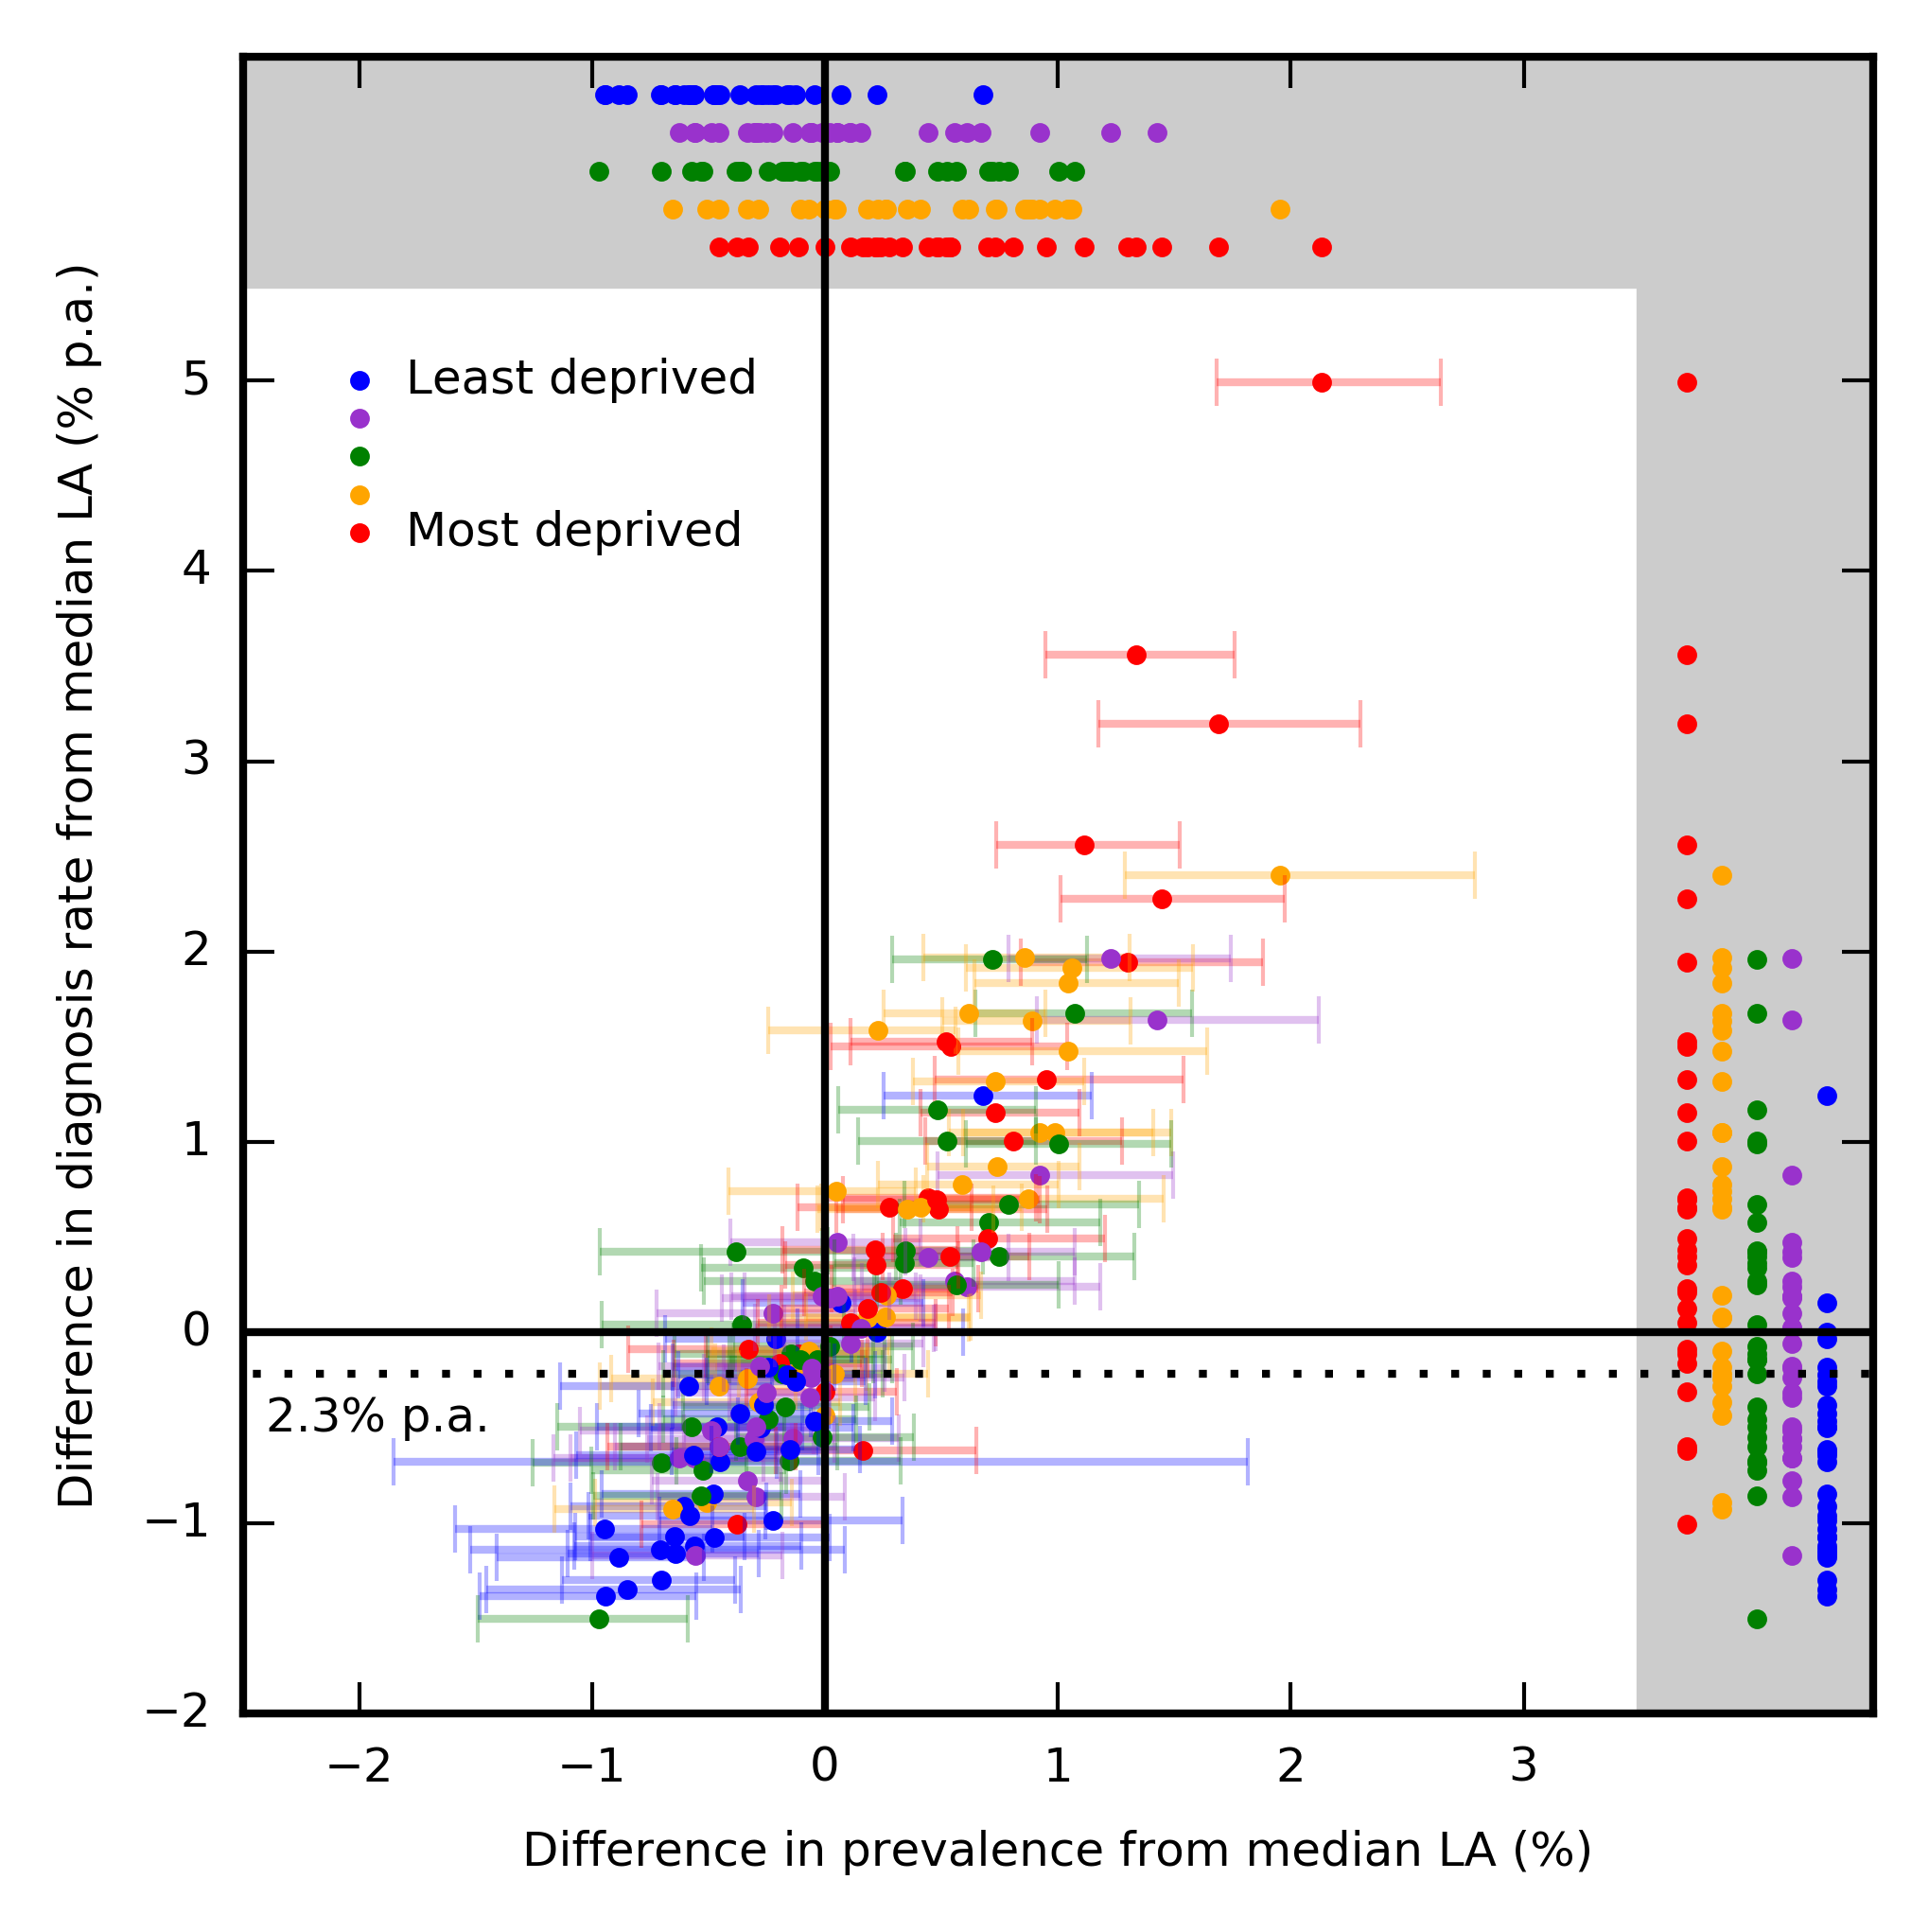

In [14]:
p_active_f = 0.8189215

quantiles_f = percentile(prev_f_la - tile(transpose([prev_f_la[:,mi_f]]), [1,151]), [50,2.5,97.5], 0)

figcd = plt.figure(figsize = (3.5,3.5))

ax2 = figcd.add_subplot(111)
ax2.tick_params(axis='both', labelsize=6)

from matplotlib.patches import Polygon
ax2.add_patch(Polygon(array([[-3,5.5],[-3,10],[10,10],[10,-3],[3.5,-3],[3.5,5.5]]), closed=True, color='0.8'))

for i in las.index:
    
    if (len(quantiles_f[0][where(alldata.la_code == i)])>0): # not the Scilly Isles
                    
        if str(las.quintile[i]) == '(30.457, 43.446]':
            pcol = 'r'#array((195,92,164))/255.
            offset = 0
        elif str(las.quintile[i]) == '(25.409, 30.457]':
            pcol = 'orange'#array((203,91,76))/255.
            offset = 0.2
        elif str(las.quintile[i]) == '(20.215, 25.409]':
            pcol = 'g'#array((175,150,62))/255.
            offset = 0.4
        elif str(las.quintile[i]) == '(15.298, 20.215]':
            pcol = 'darkorchid'#array((91,169,101))/255.
            offset = 0.6
        elif str(las.quintile[i]) == '(5.445, 15.298]':
            pcol = 'b'#array((117,123,205))/255.
            offset = 0.8
        else:
            print 'no color'
            
        msty = pcol

        ax2.plot(p_active_f*100*quantiles_f[0][where(alldata.la_code == i)],
                 100*alldata['positives.female.total'][where(alldata.la_code == i)[0]]/ \
            (alldata['population.female.15-19'][where(alldata.la_code == i)[0]] + \
                     alldata['population.female.20-24'][where(alldata.la_code == i)[0]]) - 100.0*dr_med_f,
                'o', markerfacecolor = msty, markeredgecolor = pcol, markersize=2) # + 5*(i in las_ofinterest))
        ax2.errorbar(100.0*p_active_f*quantiles_f[0,where(alldata.la_code == i)],
                  100*alldata['positives.female.total'][where(alldata.la_code == i)[0]]/ \
            (alldata['population.female.15-19'][where(alldata.la_code == i)[0]] + \
                     alldata['population.female.20-24'][where(alldata.la_code == i)[0]]) - 100.0*dr_med_f,
                  xerr=array([[100.0*p_active_f*(quantiles_f[0]-quantiles_f[1])[where(alldata.la_code == i)]],
                       [100.0*p_active_f*(min(quantiles_f[2,where(alldata.la_code == i)],0.05/p_active_f)-quantiles_f[0,where(alldata.la_code == i)])]]),
                  linestyle = 'None', color = pcol, alpha=0.3
                  )
        # vertical bar
        ax2.plot(3.7 + 0.15*offset/0.2,
                 100*alldata['positives.female.total'][where(alldata.la_code == i)[0]]/ \
            (alldata['population.female.15-19'][where(alldata.la_code == i)[0]] + \
                     alldata['population.female.20-24'][where(alldata.la_code == i)[0]]) - 100.0*dr_med_f,
                'o', markerfacecolor = msty, markeredgecolor = pcol, markersize=2)
        # horizontal bar
        ax2.plot(p_active_f*100*quantiles_f[0][where(alldata.la_code == i)],
                 5.7 + offset,
                'o', markerfacecolor = msty, markeredgecolor = pcol, markersize=2)

ax2.set_xlim([-2.5,4.5])
ax2.set_ylim([-2,6.7])
ax2.set_xlabel('Difference in prevalence from median LA (%)', size=6)
ax2.set_ylabel('Difference in diagnosis rate from median LA (% p.a.)', size=6)
ax2.set_xticks(range(-2,4))
ax2.set_yticks(range(-2,6))
ax2.plot([-3,10],[2.3 - 100.0*dr_med_f, 2.3 - 100.0*dr_med_f], ':k')
ax2.text(-2.4, 2 - 100.0*dr_med_f, '2.3% p.a.', size=6)
ax2.plot([-10,10], [0,0], 'k')
ax2.plot([0,0], [-10,10], 'k')
#ax2.plot([0,5,5],[7.8,7.8,0],'0.5')

ax2.plot(-2, 5, '.', color = 'b', markersize = 4)
ax2.plot(-2, 4.8, '.', color = 'darkorchid', markersize=4)
ax2.plot(-2, 4.6, '.', color = 'g', markersize=4)
ax2.plot(-2, 4.4, '.', color = 'orange', markersize=4)
ax2.plot(-2, 4.2, '.', color = 'r', markersize=4)
ax2.text(-1.8, 4.2, 'Most deprived', verticalalignment = 'center', size=6)
ax2.text(-1.8, 5, 'Least deprived', verticalalignment = 'center', size=6)

plt.tight_layout()

The plot shows differences in diagnosis rates vs differences in estimated prevalence from the median LA. The horizontal dotted line indicates a diagnosis rate of 2.3% p.a.

In this and subsequent plots, marker colour indicates the LA’s deprivation quintile (red is most deprived and blue least deprived) and vertical lines of dots to the right of the plot and horizontal lines of dots above the plot are, respectively, projections of the plotted points with respect to each axis so that the range of values spanned by each quintile can be clearly seen. Quintiles are arranged in order from the most-deprived to the least-deprived.

We check the Spearman correlation: first, using median posterior sample and then for every sample, reporting selected centiles.

In [15]:
print spearmanr(
        quantiles_f[0,:],
        alldata['positives.female.total']/ \
            (alldata['population.female.15-19'] + alldata['population.female.20-24'])
    )

(0.92384105960264884, 5.0972949553696901e-64)


In [16]:
# examine the Spearman correlation by sample

spearman = empty([n_sample])
p_val = empty([n_sample])

for i in xrange(n_sample):
    cor_f = spearmanr(
        prev_f_la[i],
        alldata['positives.female.total']/ \
            (alldata['population.female.15-19'] + alldata['population.female.20-24'])
        )
    spearman[i] = cor_f[0]
    p_val[i] = cor_f[1]

    
# find the (0, 2.5, 25, 50, 75, 97.5, 100)th centiles of the correlations 
print percentile(spearman, [0,2.5,25,50,75,97.5,100], axis=0)
    
# find the (0, 2.5, 25, 50, 75, 97.5, 100)th centiles of the p-values, 
print percentile(p_val, [0,2.5,25,50,75,97.5,100], axis=0)

[ 0.75328337  0.82926054  0.87755925  0.89734925  0.9136999   0.93858174
  0.96300802]
[  9.49456946e-87   9.71612230e-71   3.85205885e-60   8.49991813e-55
   2.01232956e-49   1.74999056e-39   6.62610894e-29]


### Inequalities in diagnosis rate vs inequalities in incidence

We now examine the relationship between inequalities in diagnosis rate and inequalities in incidence.

In [17]:
# which is the median-incidence LA?
mi_f = argsort(percentile(inc_f_la*(1 - prev_f_la), 50, 0))[len(percentile(prev_f_la, 50, 0))//2]
print alldata.la[mi_f]

Sefton


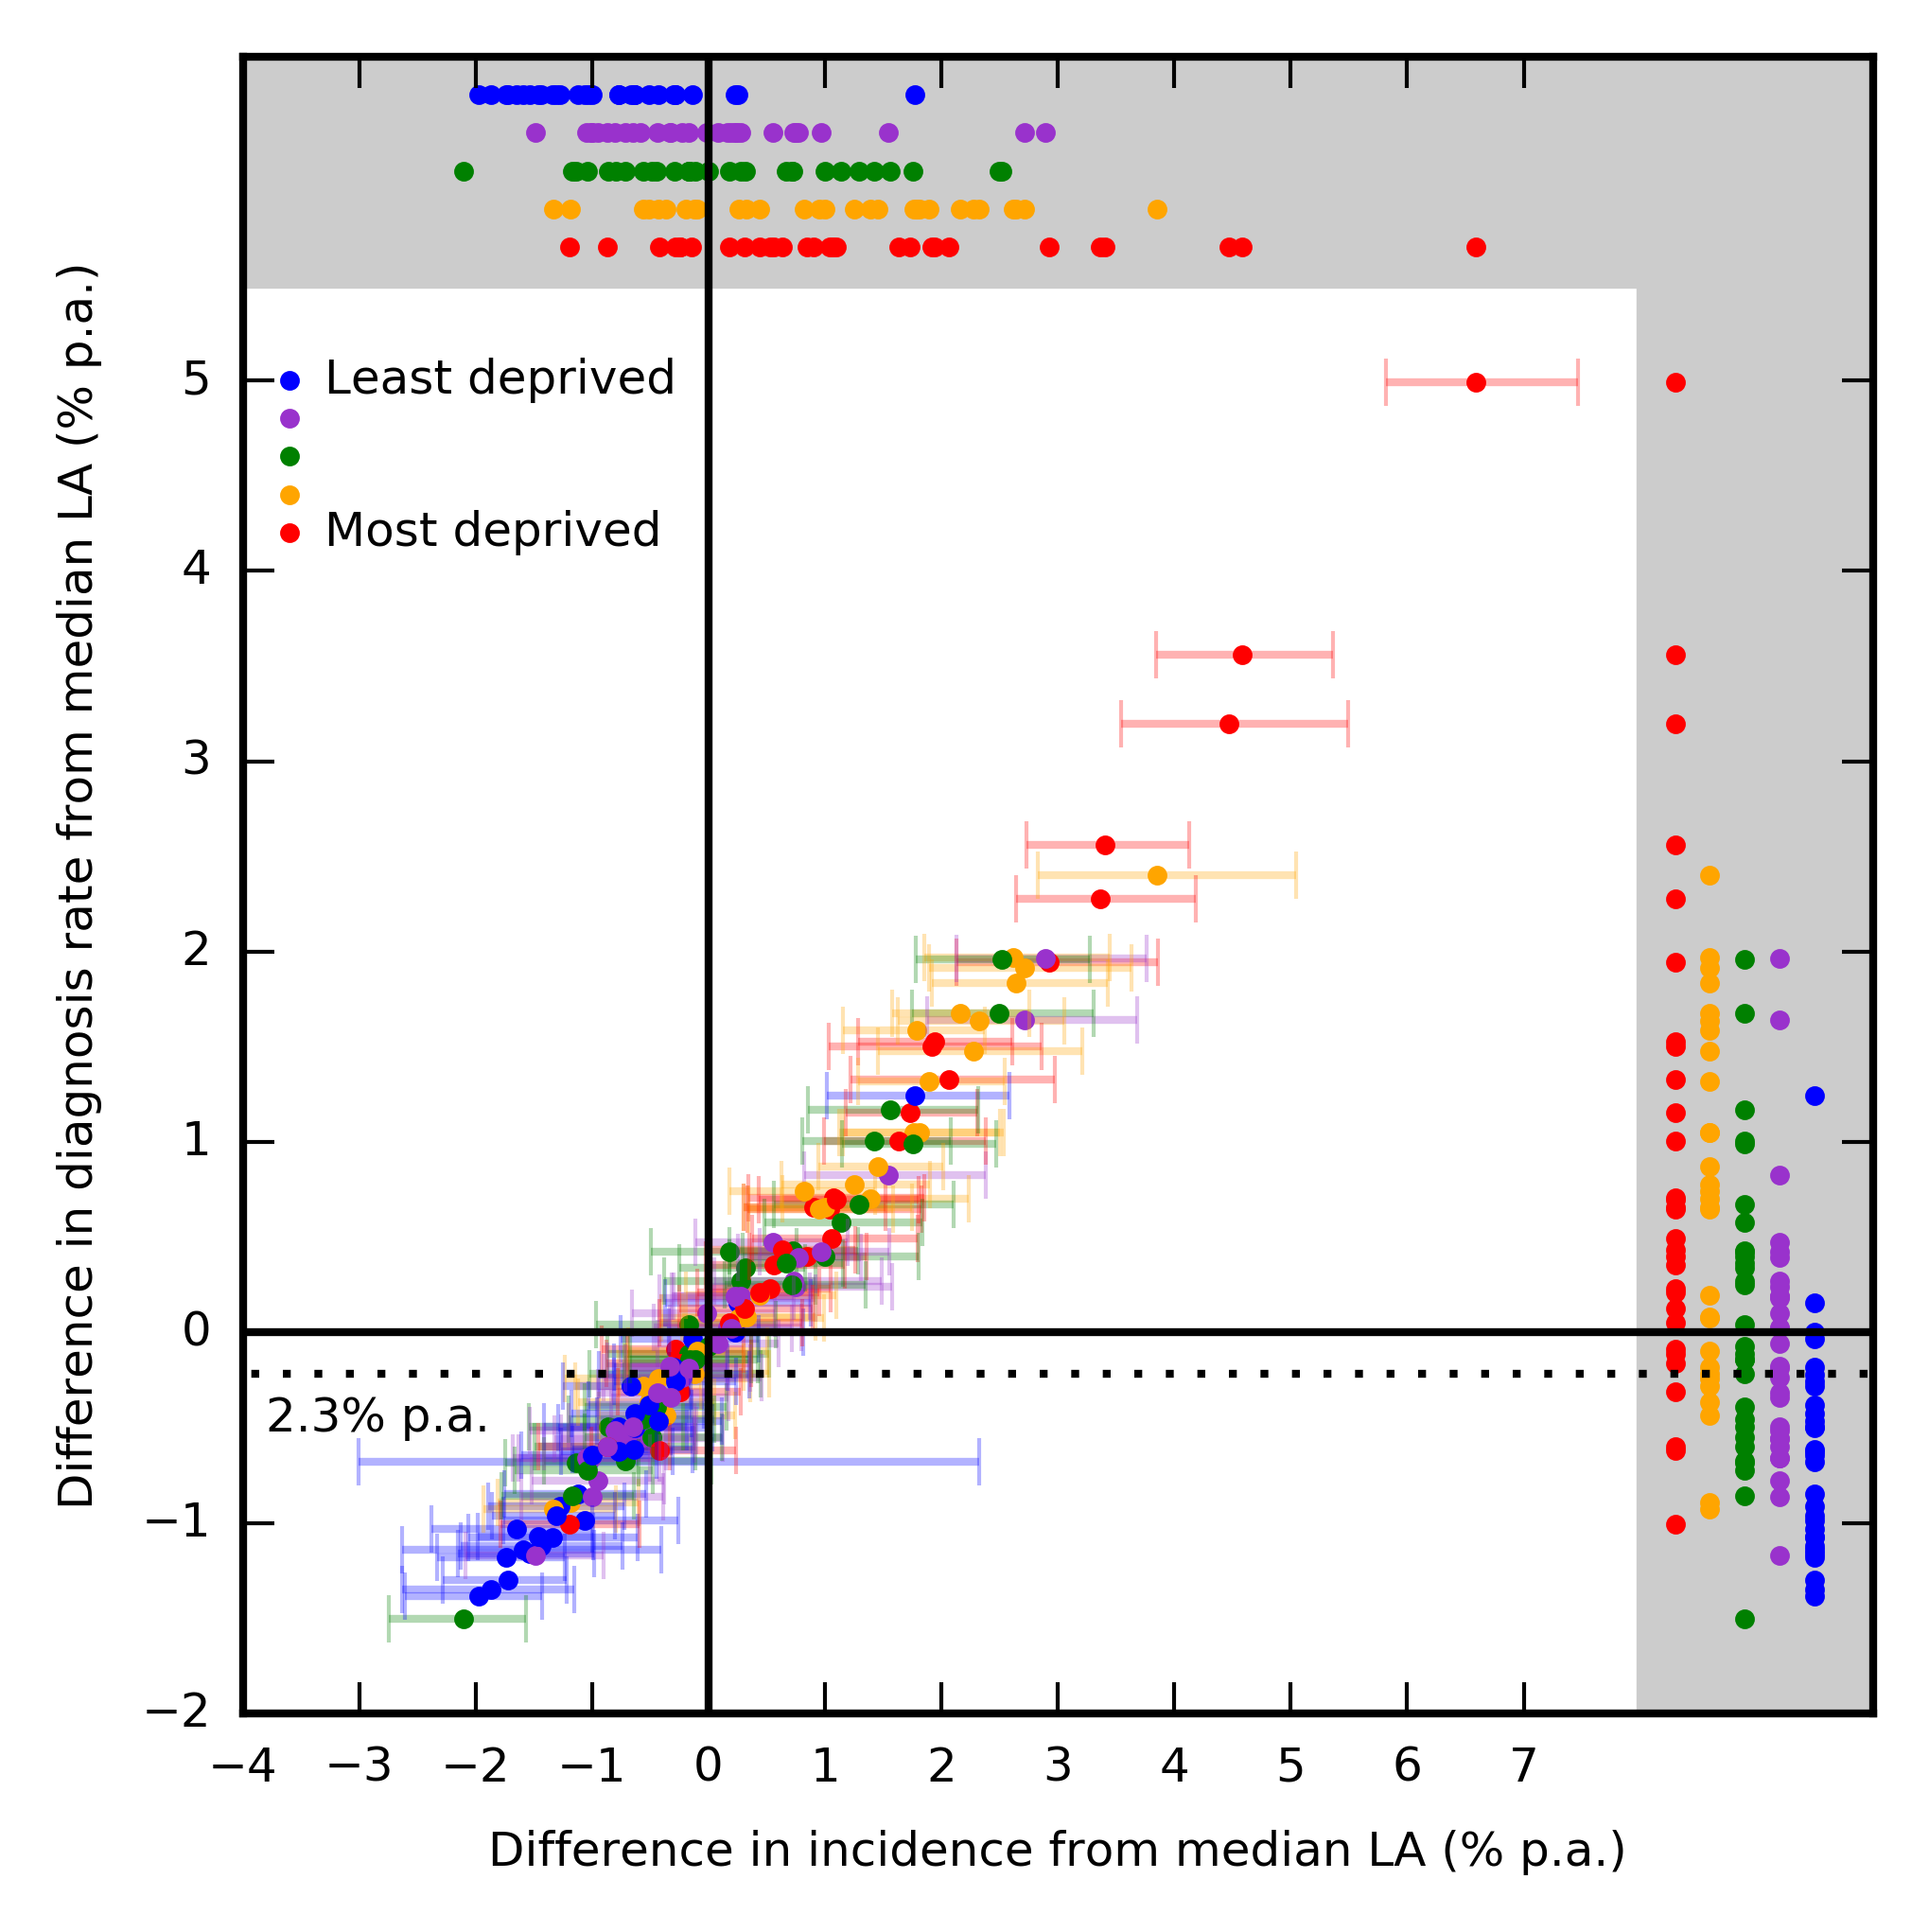

In [18]:
quantiles_f = percentile(inc_f_la*(1 - prev_f_la) - tile(transpose([inc_f_la[:,mi_f]*(1 - prev_f_la[:,mi_f])]), [1,151]), [50,2.5,97.5], 0)

figcd = plt.figure(figsize = (3.5,3.5))
ax2 = figcd.add_subplot(111)
ax2.tick_params(axis='both', labelsize=6)

ax2.add_patch(Polygon(array([[-5,5.5],[-5,10],[20,10],[20,-3],[8,-3],[8,5.5]]), closed=True, color='0.8'))

for i in las.index:
    
    if (len(quantiles_f[0][where(alldata.la_code == i)])>0): # not the Scilly Isles
                    
        if str(las.quintile[i]) == '(30.457, 43.446]':
            pcol = 'r'#array((195,92,164))/255.
            offset = 0
        elif str(las.quintile[i]) == '(25.409, 30.457]':
            pcol = 'orange'#array((203,91,76))/255.
            offset = 0.2
        elif str(las.quintile[i]) == '(20.215, 25.409]':
            pcol = 'g'#array((175,150,62))/255.
            offset = 0.4
        elif str(las.quintile[i]) == '(15.298, 20.215]':
            pcol = 'darkorchid'#array((91,169,101))/255.
            offset = 0.6
        elif str(las.quintile[i]) == '(5.445, 15.298]':
            pcol = 'b'#array((117,123,205))/255.
            offset = 0.8
        else:
            print 'no color'
            
        msty = pcol

        ax2.plot(p_active_f*100*quantiles_f[0][where(alldata.la_code == i)],
                 100*alldata['positives.female.total'][where(alldata.la_code == i)[0]]/ \
            (alldata['population.female.15-19'][where(alldata.la_code == i)[0]] + \
                     alldata['population.female.20-24'][where(alldata.la_code == i)[0]]) - 100.0*dr_med_f,
                'o', markerfacecolor = msty, markeredgecolor = pcol, markersize=2) # + 5*(i in las_ofinterest))
        ax2.errorbar(100.0*p_active_f*quantiles_f[0,where(alldata.la_code == i)],
                  100*alldata['positives.female.total'][where(alldata.la_code == i)[0]]/ \
            (alldata['population.female.15-19'][where(alldata.la_code == i)[0]] + \
                     alldata['population.female.20-24'][where(alldata.la_code == i)[0]]) - 100.0*dr_med_f,
                  xerr=array([[100.0*p_active_f*(quantiles_f[0]-quantiles_f[1])[where(alldata.la_code == i)]],
                       [100.0*p_active_f*(min(quantiles_f[2,where(alldata.la_code == i)],0.13/p_active_f)-quantiles_f[0,where(alldata.la_code == i)])]]),
                  linestyle = 'None', color = pcol, alpha=0.3
                  )
        # vertical bar
        ax2.plot(8.3 + 0.3*offset/0.2,
                 100*alldata['positives.female.total'][where(alldata.la_code == i)[0]]/ \
            (alldata['population.female.15-19'][where(alldata.la_code == i)[0]] + \
                     alldata['population.female.20-24'][where(alldata.la_code == i)[0]]) - 100.0*dr_med_f,
                'o', markerfacecolor = msty, markeredgecolor = pcol, markersize=2)
        # horizontal bar
        ax2.plot(p_active_f*100*quantiles_f[0][where(alldata.la_code == i)],
                 5.7 + offset,
                'o', markerfacecolor = msty, markeredgecolor = pcol, markersize=2)

ax2.set_xlim([-4,10])
ax2.set_ylim([-2,6.7])
ax2.set_xlabel('Difference in incidence from median LA (% p.a.)', size=6)
ax2.set_ylabel('Difference in diagnosis rate from median LA (% p.a.)', size=6)
ax2.set_xticks(range(-4,8))
ax2.set_yticks(range(-2,6))
ax2.plot([-10,10],[2.3 - 100.0*dr_med_f, 2.3 - 100.0*dr_med_f], ':k')
ax2.text(-3.8, 2 - 100.0*dr_med_f, '2.3% p.a.', size=6)
ax2.plot([0,0],[-20,20], 'k')
ax2.plot([-20,20],[0,0], 'k')
#ax2.plot([0,5,5],[7.8,7.8,0],'0.5')

ax2.plot(-3.6, 5, '.', color = 'b', markersize = 4)
ax2.plot(-3.6, 4.8, '.', color = 'darkorchid', markersize=4)
ax2.plot(-3.6, 4.6, '.', color = 'g', markersize=4)
ax2.plot(-3.6, 4.4, '.', color = 'orange', markersize=4)
ax2.plot(-3.6, 4.2, '.', color = 'r', markersize=4)
ax2.text(-3.3, 4.2, 'Most deprived', verticalalignment = 'center', size=6)
ax2.text(-3.3, 5, 'Least deprived', verticalalignment = 'center', size=6)

plt.tight_layout()

The plot shows differences in diagnosis rates vs differences in estimated incidence from the median LA. The horizontal dotted line indicates a diagnosis rate of 2.3% p.a.

We check the Spearman correlation: first, using median posterior sample and then for every sample, reporting selected centiles.


In [19]:
print spearmanr(
        percentile(inc_f_la*(1 - prev_f_la),50,0),
        alldata['positives.female.total']/ \
            (alldata['population.female.15-19'] + alldata['population.female.20-24'])
    )

(0.99149529452770979, 7.3578507744674225e-134)


In [20]:
# examine the Spearman correlation by sample

spearman = empty([n_sample])
p_val = empty([n_sample])

for i in xrange(n_sample):
    cor_f = spearmanr(
        inc_f_la[i]*(1 - prev_f_la[i]),
        alldata['positives.female.total']/ \
            (alldata['population.female.15-19'] + alldata['population.female.20-24'])
        )
    spearman[i] = cor_f[0]
    p_val[i] = cor_f[1]

    
# find the (0, 2.5, 25, 50, 75, 97.5, 100)th centiles of the correlations 
print percentile(spearman, [0,2.5,25,50,75,97.5,100], axis=0)
    
# find the (0, 2.5, 25, 50, 75, 97.5, 100)th centiles of the p-values, 
print percentile(p_val, [0,2.5,25,50,75,97.5,100], axis=0)

[ 0.92159638  0.94989509  0.96793221  0.97433426  0.97898571  0.98485195
  0.98956082]
[  2.93200999e-127   2.74458612e-115   8.63064032e-105   2.14514629e-098
   2.71946682e-091   3.83315091e-077   4.07796152e-063]


## Inequalities in the proportion of infections untreated

We now examine relationship between inequalities in the proportion of infections untreated and inequalities in incidence and diagnosis rate.

### Inequalities in the proportion of infections untreated vs inequalities in incidence

In [21]:
# which is the median-incidence LA?
mi_f = argsort(percentile(inc_f_la*(1 - prev_f_la), 50, 0))[len(percentile(prev_f_la, 50, 0))//2]
print alldata.la[mi_f]


Sefton


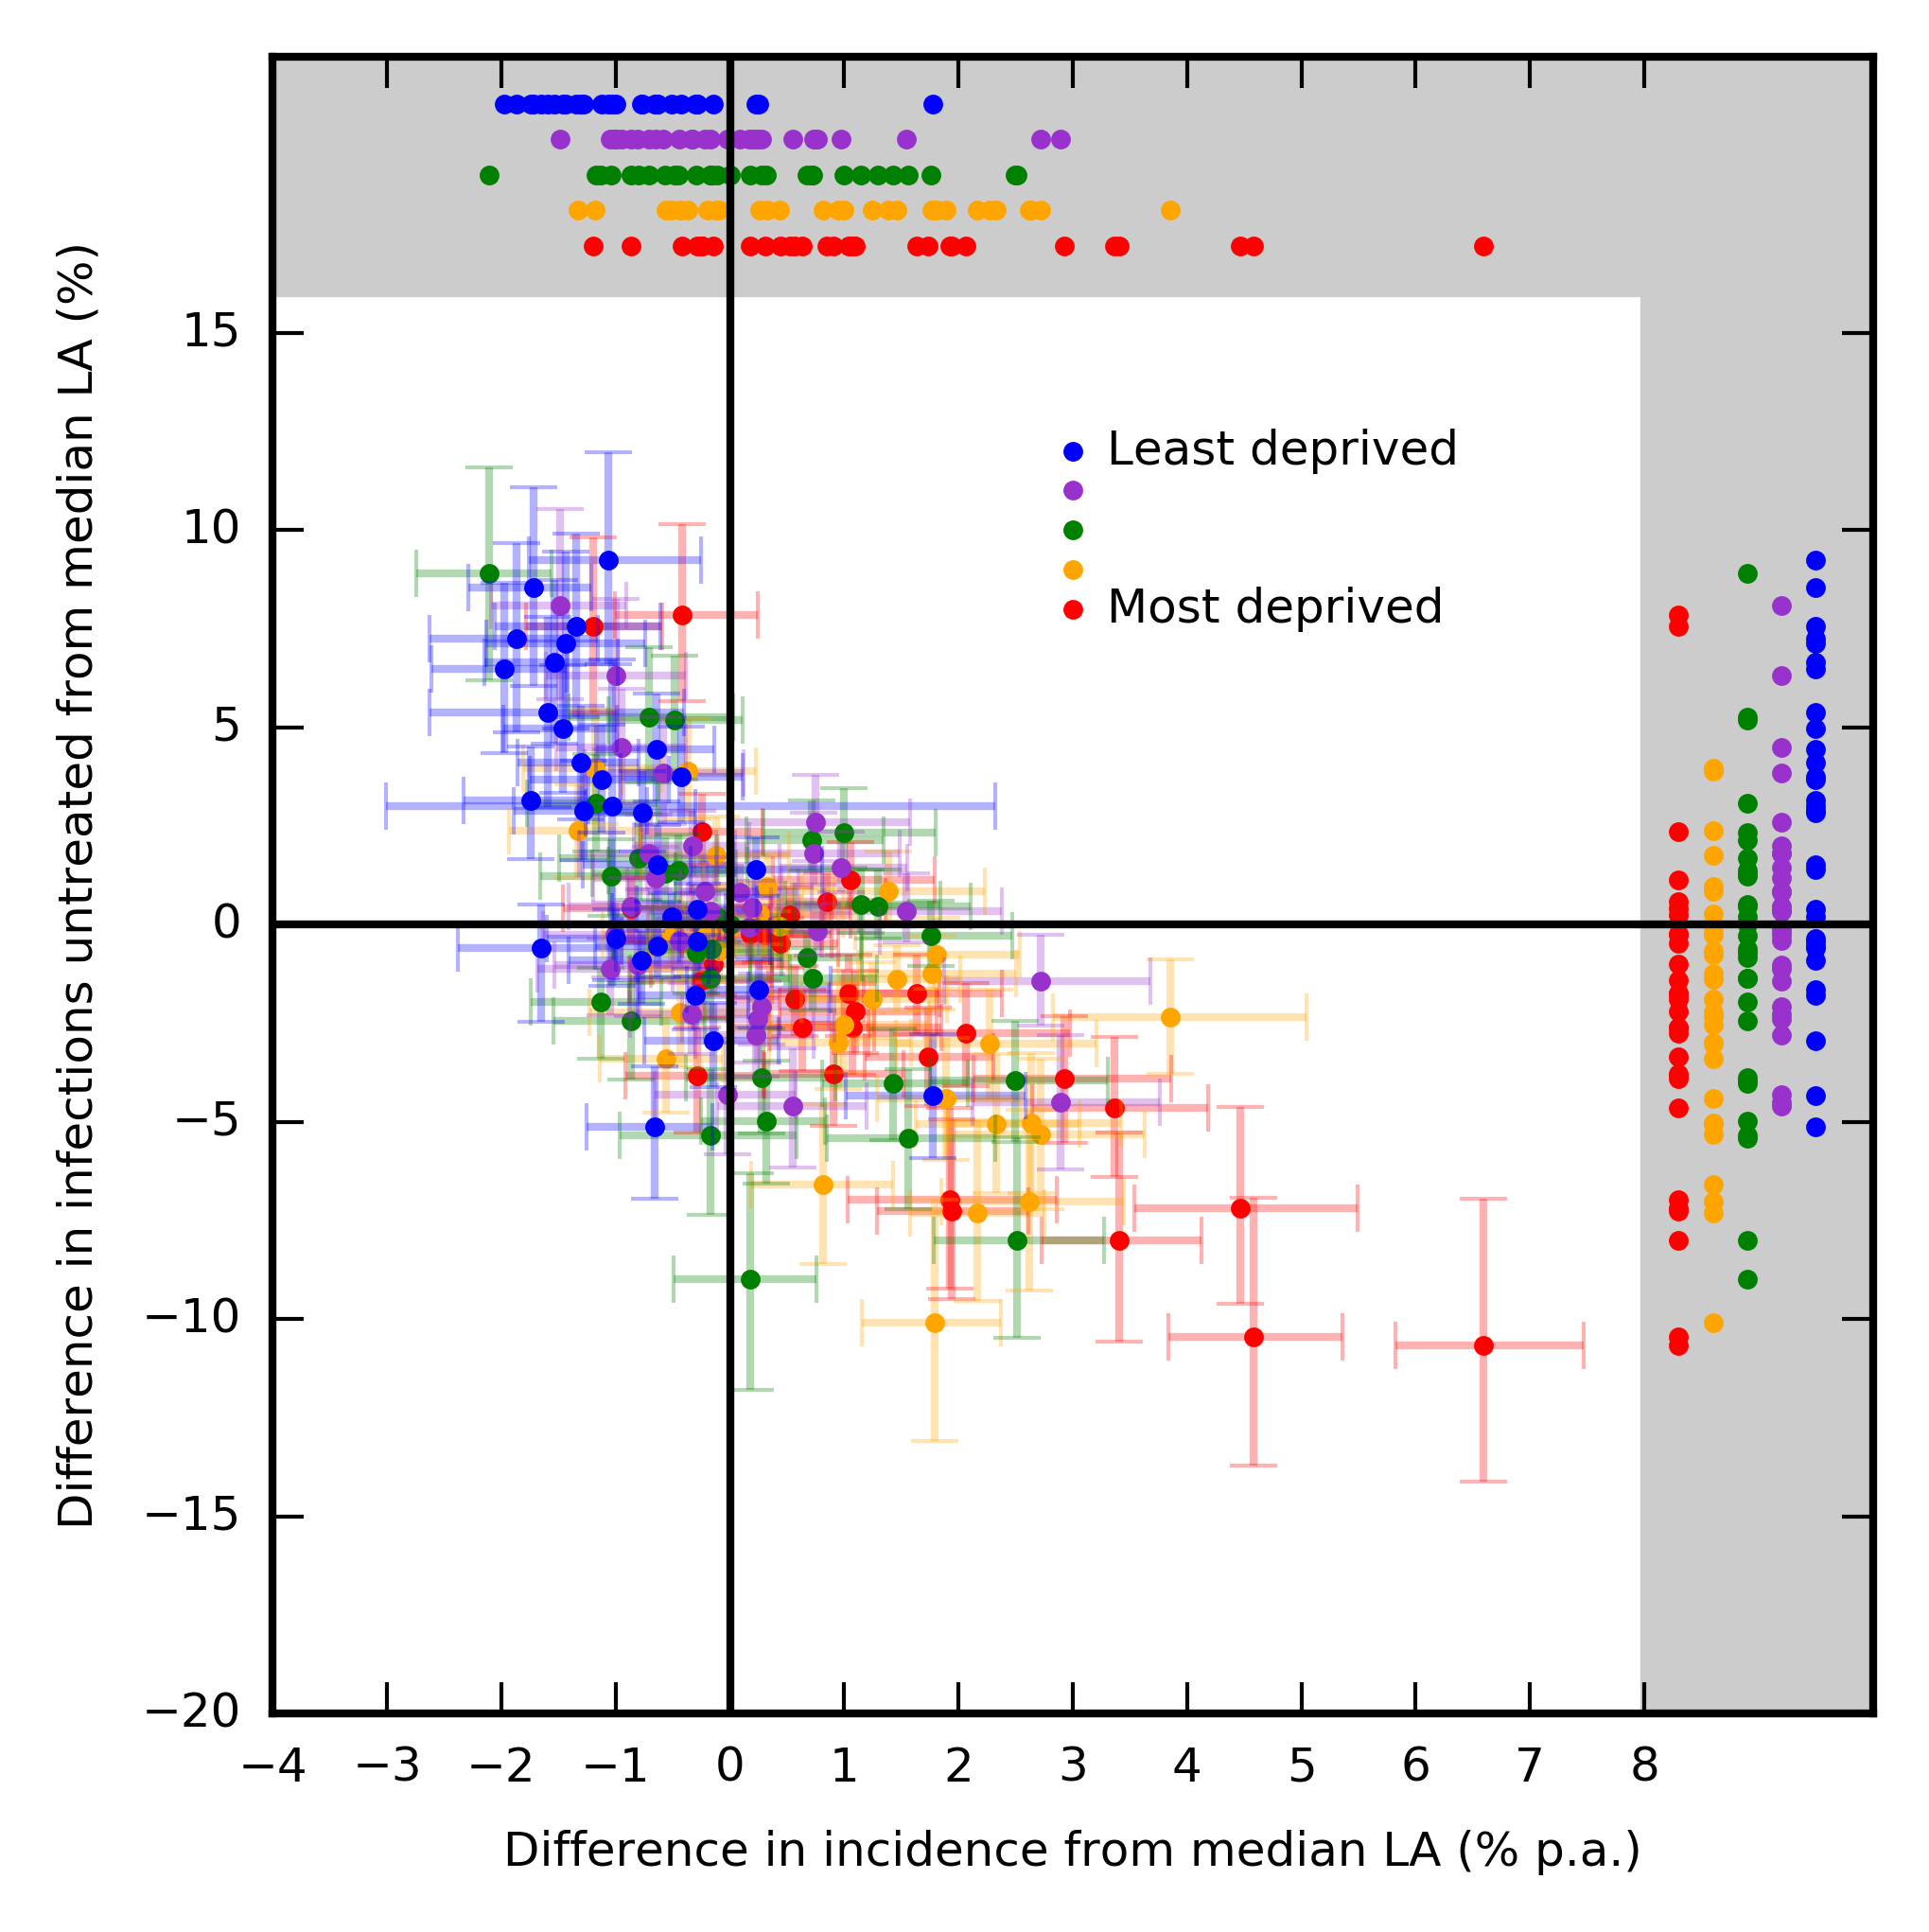

In [22]:
import matplotlib.colors

alldata["offset"] = np.nan
alldata["color"] = np.nan

fig = plt.figure(figsize = (3.5,3.5))
ax4 = fig.add_subplot(111)
ax4.tick_params(axis='both', labelsize=6)

ax4.add_patch(Polygon(array([[-100,16],[-100,100],[100,100],[100,-100],[8,-100],[8,16]]), closed=True, color='0.8'))

adpc_f = 100.*alldata['positives.female.total']/ \
                (alldata['population.female.15-19'] + \
                alldata['population.female.20-24'])    
    
adpc_tot_notmet = 1.*((alldata['positives.male.total'] + alldata['positives.female.total'])/ \
            (alldata['population.male.15-19'] + alldata['population.female.15-19'] + \
            alldata['population.male.20-24'] + alldata['population.female.20-24'])) < 0.023    


quantiles_ann_infect_diff_f = p_active_f * percentile(inc_f_la*(1 - prev_f_la) - tile(transpose([inc_f_la[:,mi_f]*(1 - prev_f_la[:,mi_f])]), [1,151]), [50,2.5,97.5], 0)
quantiles_prop_not_treated_diff_f = percentile(-(diag_sample_f / (inc_f_la*(1 - prev_f_la))) 
                                            + tile(transpose([(diag_sample_f[:,mi_f] / (inc_f_la[:,mi_f]*(1 - prev_f_la[:,mi_f])))]), [1,151]), 
                                          [50,2.5,97.5], 0)

av_ann_infect_f = 100*p_active_f * percentile(inc_f*(1 - prev_f), 50)

for i in las.index:
    
    if str(las.quintile[i]) == '(30.457, 43.446]':
        alldata.offset[where(alldata.la_code == i)[0]] = 0
#        alldata.color[where(alldata.la_code == i)[0]] = 'r'
    elif str(las.quintile[i]) == '(25.409, 30.457]':
        alldata.offset[where(alldata.la_code == i)[0]] = 1
#        alldata.color[where(alldata.la_code == i)[0]] = 'orange'
    elif str(las.quintile[i]) == '(20.215, 25.409]':
        alldata.offset[where(alldata.la_code == i)[0]] = 2
#        alldata.color[where(alldata.la_code == i)[0]] = 'g'
    elif str(las.quintile[i]) == '(15.298, 20.215]':
        alldata.offset[where(alldata.la_code == i)[0]] = 3
#        alldata.color[where(alldata.la_code == i)[0]] = 'darkorchid'
    elif str(las.quintile[i]) == '(5.445, 15.298]':
        alldata.offset[where(alldata.la_code == i)[0]] = 4
#        alldata.color[where(alldata.la_code == i)[0]] = 'blue'
    else:
        print 'no color'

colordict = {0:'None', 1:'r', 2:'orange', 3:'g', 4:'darkorchid', 5:'b'}
bdict = {0:True, 1:False}

for i in range(5):
    for j in range(2): # can multiply marker face colour by j to plot empty markers for LAs not meeting targets

        ax4.plot(100*quantiles_ann_infect_diff_f[0][where((alldata.offset == i) & (adpc_tot_notmet == bdict[j]))],
            100*quantiles_prop_not_treated_diff_f[0][where((alldata.offset == i) & (adpc_tot_notmet == bdict[j]))],
            'o', markerfacecolor=colordict[(i+1)], markeredgecolor=colordict[i+1],markersize=2
            )    
        ax4.errorbar(100*quantiles_ann_infect_diff_f[0][where((alldata.offset == i) & (adpc_tot_notmet == bdict[j]))],
            100*quantiles_prop_not_treated_diff_f[0][where((alldata.offset == i) & (adpc_tot_notmet == bdict[j]))],
            xerr=array([100*(quantiles_ann_infect_diff_f[0]-quantiles_ann_infect_diff_f[1])[where((alldata.offset == i) & (adpc_tot_notmet == bdict[j]))],
                        100*(quantiles_ann_infect_diff_f[2]-quantiles_ann_infect_diff_f[0])[where((alldata.offset == i) & (adpc_tot_notmet == bdict[j]))]]),
            yerr=array([100*(quantiles_prop_not_treated_diff_f[0]-quantiles_prop_not_treated_diff_f[1])[where((alldata.offset == i) & (adpc_tot_notmet == bdict[j]))],
                        100*(quantiles_prop_not_treated_diff_f[2]-quantiles_prop_not_treated_diff_f[0])[where((alldata.offset == i) & (adpc_tot_notmet == bdict[j]))]]),
            linestyle = 'None', color = colordict[(i+1)], alpha=0.3)
        # vertical bar
        ax4.plot(8.3 + 0.3*i + 0*quantiles_prop_not_treated_diff_f[0][where((alldata.offset == i) & (adpc_tot_notmet == bdict[j]))],
            100*quantiles_prop_not_treated_diff_f[0][where((alldata.offset == i) & (adpc_tot_notmet == bdict[j]))],
            'o', markerfacecolor=colordict[(i+1)], markeredgecolor=colordict[i+1],markersize=2
            )    
        # horizontal bar
        ax4.plot(100*quantiles_ann_infect_diff_f[0][where((alldata.offset == i) & (adpc_tot_notmet == bdict[j]))],
            17.2 + 0.9*i + 0*quantiles_prop_not_treated_diff_f[0][where((alldata.offset == i) & (adpc_tot_notmet == bdict[j]))],
            'o', markerfacecolor=colordict[(i+1)], markeredgecolor=colordict[i+1],markersize=2
            )    
        
ax4.set_xlim([-4,10])
ax4.set_xticks(range(-4,9))
ax4.set_ylim([-20,22])
ax4.set_yticks(range(-20,20,5))
ax4.set_xlabel('Difference in incidence from median LA (% p.a.)', size=6)
ax4.set_ylabel('Difference in infections untreated from median LA (%)', size=6)
ax4.plot([0,0],[-100,100], 'k')
ax4.plot([-100,100],[0,0],'k')
#ax4.plot([0,12,12],[51,51,15],'0.5')

ax4.plot(3, 12, '.', color = 'b', markersize = 4)
ax4.plot(3, 11, '.', color = 'darkorchid', markersize=4)
ax4.plot(3, 10, '.', color = 'g', markersize=4)
ax4.plot(3, 9, '.', color = 'orange', markersize=4)
ax4.plot(3, 8, '.', color = 'r', markersize=4)
ax4.text(3.3, 8, 'Most deprived', verticalalignment = 'center', size=6)
ax4.text(3.3, 12, 'Least deprived', verticalalignment = 'center', size=6)

plt.tight_layout()

The plot shows differences in estimated percentages of new infections that are untreated vs differences in estimated incidence from the median LA.

Calculate Spearman correlations:

In [23]:
print spearmanr(quantiles_prop_not_treated_f[0,:], percentile(inc_f_la*(1 - prev_f_la),50,0))

(-0.69313001045660494, 6.1133353757363704e-23)


In [24]:
# examine the Spearman correlation by sample

spearman = empty([n_sample])
p_val = empty([n_sample])

for i in xrange(n_sample):
    
    cor_f = spearmanr(
        inc_f_la[i]*(1 - prev_f_la[i]),
        1 - diag_sample_f[i] / (inc_f_la[i]*(1 - prev_f_la[i]))
        )
    spearman[i] = cor_f[0]
    p_val[i] = cor_f[1]

    
# find the (0, 2.5, 25, 50, 75, 97.5, 100)th centiles of the correlations 
print percentile(spearman, [0,2.5,25,50,75,97.5,100], axis=0)
    
# find the (0, 2.5, 25, 50, 75, 97.5, 100)th centiles of the p-values, 
print percentile(p_val, [0,2.5,25,50,75,97.5,100], axis=0)

[-0.76294876 -0.72950401 -0.69278146 -0.66821018 -0.63978651 -0.56744868
 -0.31080167]
[  5.01977697e-30   2.34552177e-26   6.55478516e-23   7.05000282e-21
   9.33036664e-19   3.03076898e-14   1.02709911e-04]


### Inequalities in the proportion of infections untreated vs inequalities in diagnosis rate

Finally, we look at the relationship between inequalities in the proportion of infections untreated and inequalities in diagnosis rate.

In [25]:
# which is the median-diagnosis rate LA?
mi_f = argsort(percentile(diag_sample_f, 50, 0))[len(percentile(diag_sample_f, 50, 0))//2]
print alldata.la[mi_f]


Wiltshire


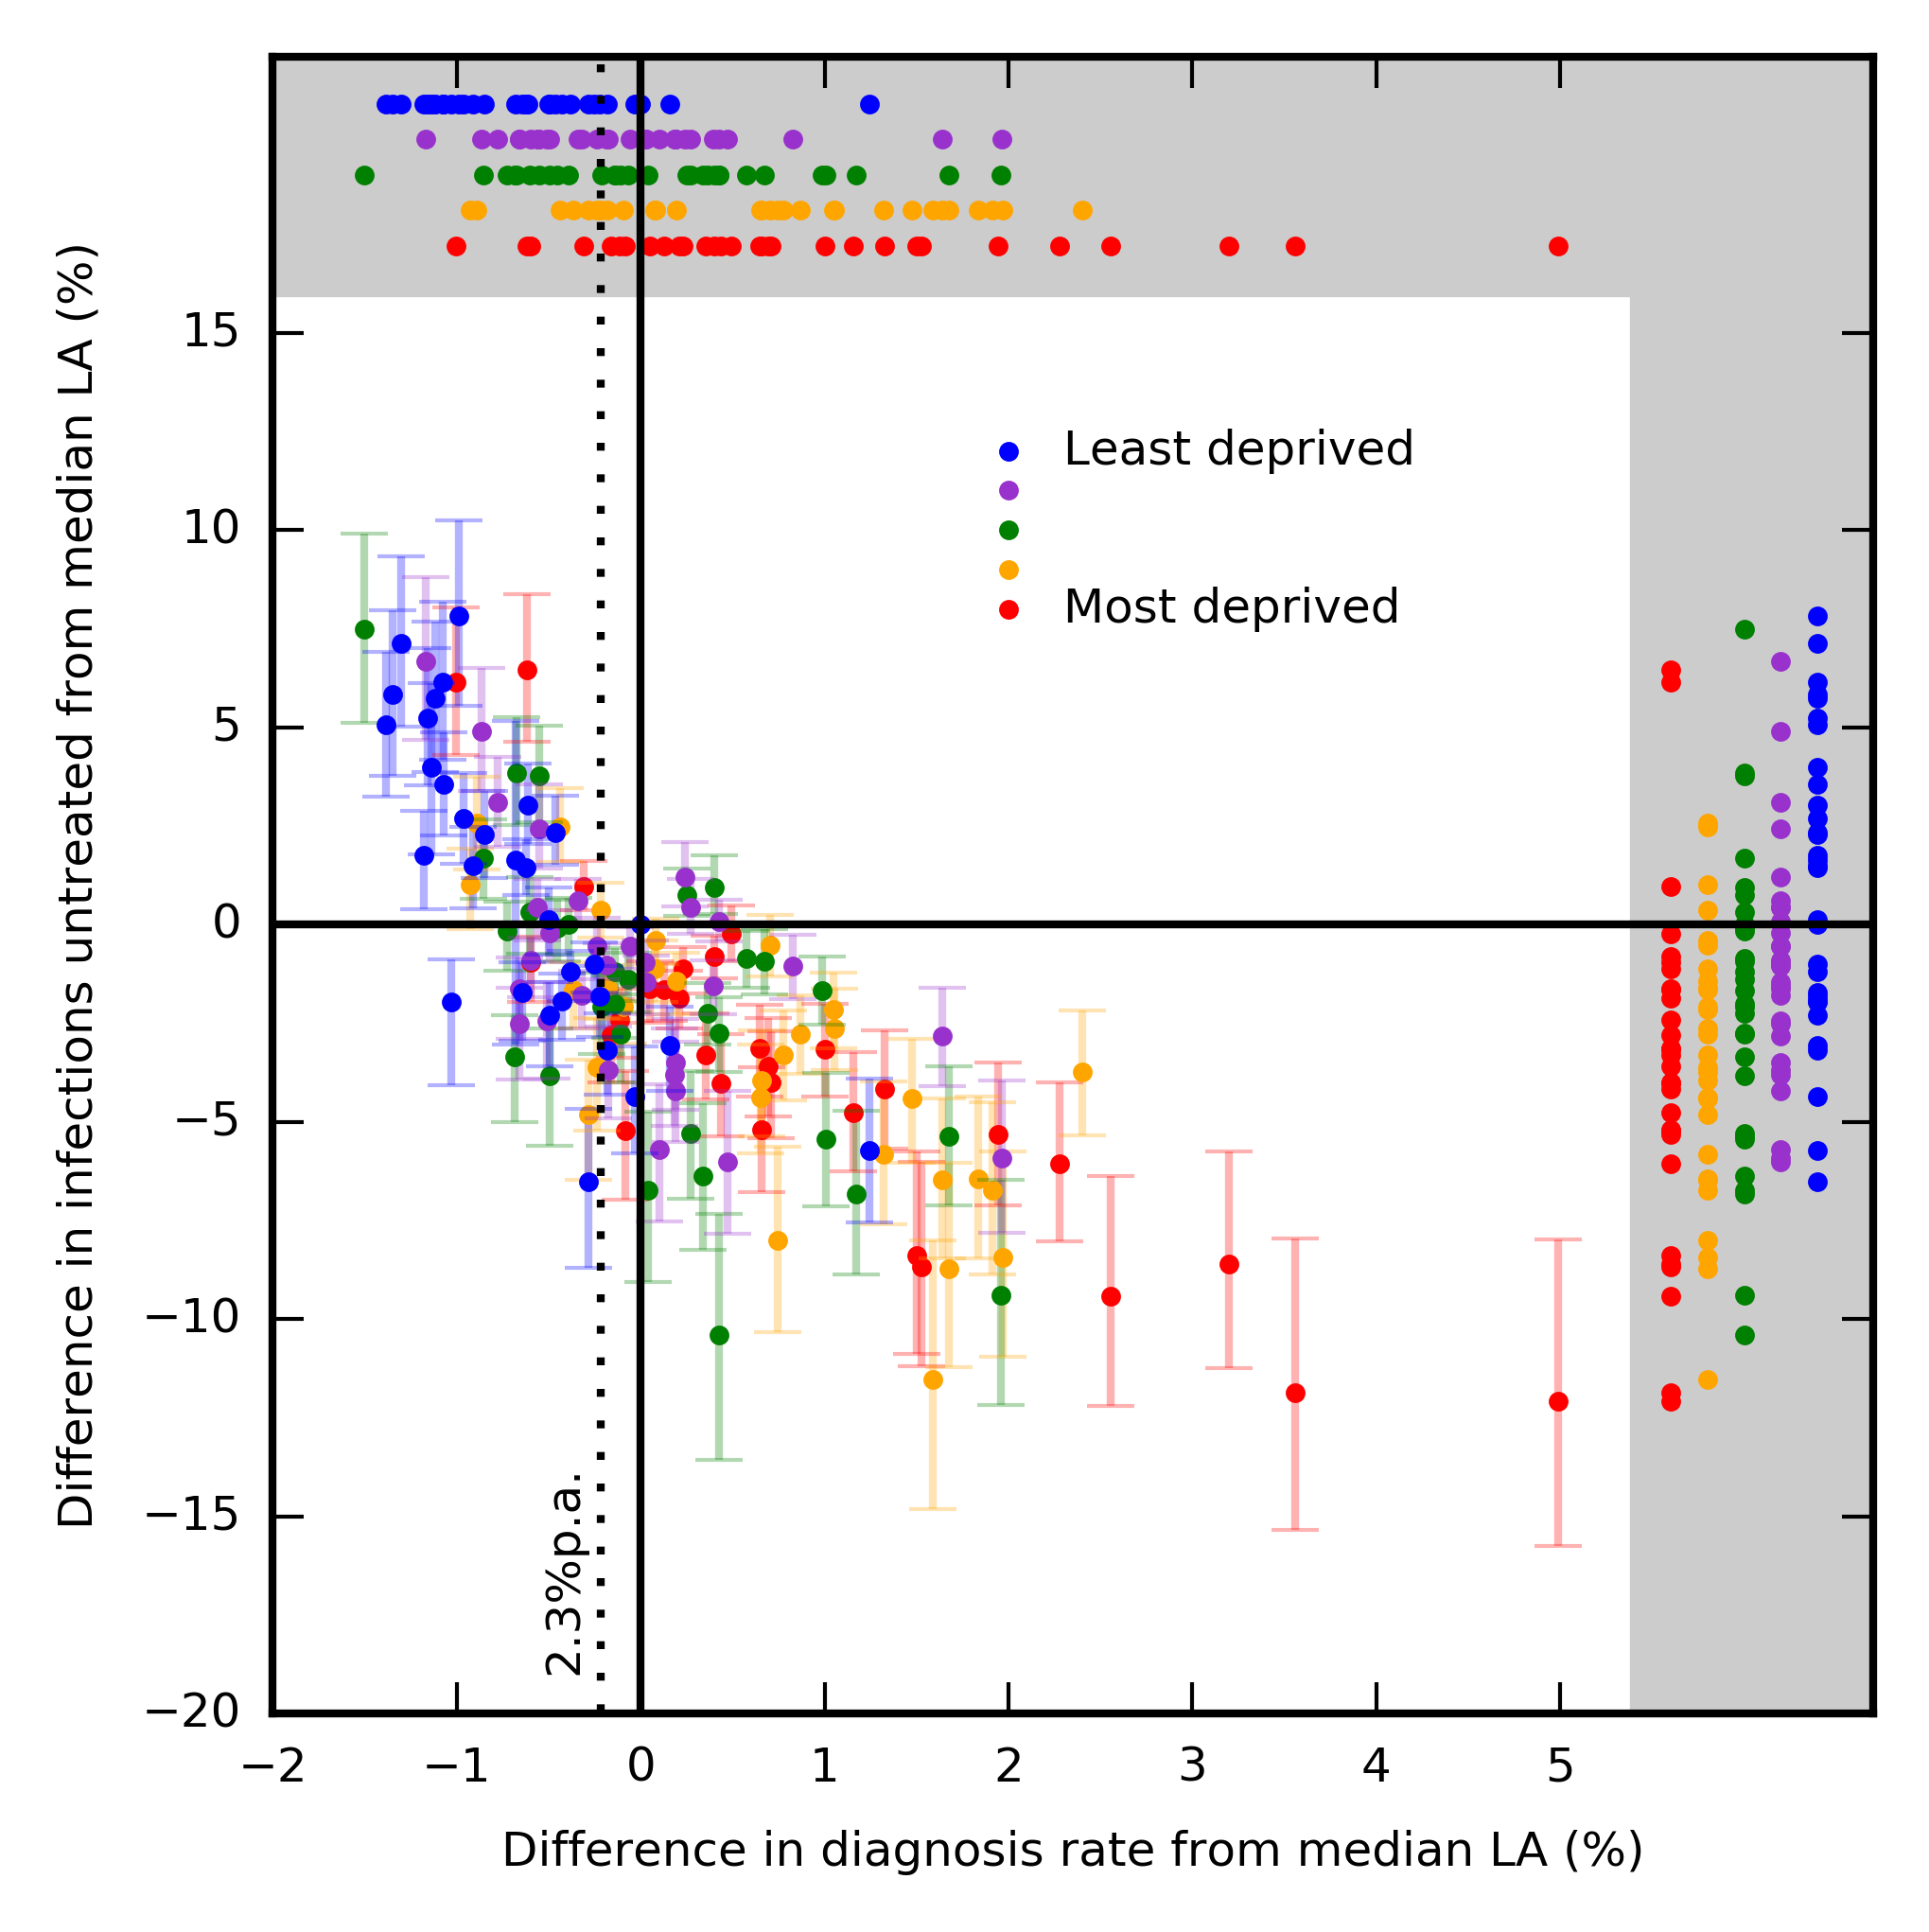

In [26]:
quantiles_prop_not_treated_diff_f = percentile(-(diag_sample_f / (inc_f_la*(1 - prev_f_la))) 
                                            + tile(transpose([(diag_sample_f[:,mi_f] / (inc_f_la[:,mi_f]*(1 - prev_f_la[:,mi_f])))]), [1,151]), 
                                          [50,2.5,97.5], 0)

alldata["offset"] = np.nan
alldata["color"] = np.nan

fig = plt.figure(figsize = (3.5,3.5))
ax4 = fig.add_subplot(111)
ax4.tick_params(axis='both', labelsize=6)

ax4.add_patch(Polygon(array([[-100,16],[-100,100],[100,100],[100,-100],[5.4,-100],[5.4,16]]), closed=True, color='0.8'))

for i in las.index:
    
    if str(las.quintile[i]) == '(30.457, 43.446]':
        alldata.offset[where(alldata.la_code == i)[0]] = 0
#        alldata.color[where(alldata.la_code == i)[0]] = 'r'
    elif str(las.quintile[i]) == '(25.409, 30.457]':
        alldata.offset[where(alldata.la_code == i)[0]] = 1
#        alldata.color[where(alldata.la_code == i)[0]] = 'orange'
    elif str(las.quintile[i]) == '(20.215, 25.409]':
        alldata.offset[where(alldata.la_code == i)[0]] = 2
#        alldata.color[where(alldata.la_code == i)[0]] = 'g'
    elif str(las.quintile[i]) == '(15.298, 20.215]':
        alldata.offset[where(alldata.la_code == i)[0]] = 3
#        alldata.color[where(alldata.la_code == i)[0]] = 'darkorchid'
    elif str(las.quintile[i]) == '(5.445, 15.298]':
        alldata.offset[where(alldata.la_code == i)[0]] = 4
#        alldata.color[where(alldata.la_code == i)[0]] = 'blue'
    else:
        print 'no color'

colordict = {0:'None', 1:'r', 2:'orange', 3:'g', 4:'darkorchid', 5:'b'}
bdict = {0:True, 1:False}

for i in range(5):
    for j in range(2): # can multiply marker face colour by j to plot empty markers for LAs not meeting targets

        ax4.plot(100*alldata['positives.female.total'][where((alldata.offset == i) & (adpc_tot_notmet == bdict[j]))[0]]/ \
            (alldata['population.female.15-19'][where((alldata.offset == i) & (adpc_tot_notmet == bdict[j]))[0]] + \
                     alldata['population.female.20-24'][where((alldata.offset == i) & (adpc_tot_notmet == bdict[j]))[0]]) - 100.0*dr_med_f,
            100*quantiles_prop_not_treated_diff_f[0][where((alldata.offset == i) & (adpc_tot_notmet == bdict[j]))],
            'o', markerfacecolor=colordict[(i+1)], markeredgecolor=colordict[i+1],markersize=2
            )    
        ax4.errorbar(100*alldata['positives.female.total'][where((alldata.offset == i) & (adpc_tot_notmet == bdict[j]))[0]]/ \
            (alldata['population.female.15-19'][where((alldata.offset == i) & (adpc_tot_notmet == bdict[j]))[0]] + \
                     alldata['population.female.20-24'][where((alldata.offset == i) & (adpc_tot_notmet == bdict[j]))[0]]) - 100.0*dr_med_f,
            100*quantiles_prop_not_treated_diff_f[0][where((alldata.offset == i) & (adpc_tot_notmet == bdict[j]))],
            yerr=array([100*(quantiles_prop_not_treated_diff_f[0]-quantiles_prop_not_treated_diff_f[1])[where((alldata.offset == i) & (adpc_tot_notmet == bdict[j]))],
                        100*(quantiles_prop_not_treated_diff_f[2]-quantiles_prop_not_treated_diff_f[0])[where((alldata.offset == i) & (adpc_tot_notmet == bdict[j]))]]),
            linestyle = 'None', color = colordict[(i+1)], alpha=0.3)
        # vertical bar
        ax4.plot(5.6 + 0.2*i + 0*quantiles_prop_not_treated_diff_f[0][where((alldata.offset == i) & (adpc_tot_notmet == bdict[j]))],
            100*quantiles_prop_not_treated_diff_f[0][where((alldata.offset == i) & (adpc_tot_notmet == bdict[j]))],
            'o', markerfacecolor=colordict[(i+1)], markeredgecolor=colordict[i+1],markersize=2
            )    
        # horizontal bar
        ax4.plot(100*alldata['positives.female.total'][where((alldata.offset == i) & (adpc_tot_notmet == bdict[j]))[0]]/ \
            (alldata['population.female.15-19'][where((alldata.offset == i) & (adpc_tot_notmet == bdict[j]))[0]] + \
                     alldata['population.female.20-24'][where((alldata.offset == i) & (adpc_tot_notmet == bdict[j]))[0]]) - 100.0*dr_med_f,
            17.2 + 0.9*i + 0*quantiles_prop_not_treated_diff_f[0][where((alldata.offset == i) & (adpc_tot_notmet == bdict[j]))],
            'o', markerfacecolor=colordict[(i+1)], markeredgecolor=colordict[i+1],markersize=2
            )    

ax4.set_xlim([-2,6.7])
ax4.set_xticks(range(-2,6))
ax4.set_ylim([-20,22])
ax4.set_yticks(range(-20,20,5))
ax4.set_xlabel('Difference in diagnosis rate from median LA (%)', size=6)
ax4.set_ylabel('Difference in infections untreated from median LA (%)', size=6)
ax4.plot([2.3 - 100.0*dr_med_f, 2.3 - 100.0*dr_med_f],[-100,100], ':k')
ax4.plot([-100,100],[0,0],'k')
ax4.plot([0,0],[-100,100],'k')
ax4.text(2.1 - 100.0*dr_med_f, -19, '2.3%p.a.', rotation = 90, va='bottom', ha='center', multialignment='left', size=6)

ax4.plot(2, 12, '.', color = 'b', markersize = 4)
ax4.plot(2, 11, '.', color = 'darkorchid', markersize=4)
ax4.plot(2, 10, '.', color = 'g', markersize=4)
ax4.plot(2, 9, '.', color = 'orange', markersize=4)
ax4.plot(2, 8, '.', color = 'r', markersize=4)
ax4.text(2.3, 8, 'Most deprived', verticalalignment = 'center', size=6)
ax4.text(2.3, 12, 'Least deprived', verticalalignment = 'center', size=6)

plt.tight_layout()

The plot shows differences in estimated percentages of new infections that are untreated vs differences in diagnosis rates from the median LA. The vertical dotted line indicates a diagnosis rate of 2.3%p.a.

Spearman correlations:


In [27]:
print spearmanr(percentile(diag_sample_f, 50, 0), percentile(1 - diag_sample_f / (inc_f_la*(1 - prev_f_la)), 50, 0) )

(-0.76696409898919482, 1.6569865523858745e-30)


In [28]:
# examine the Spearman correlation by sample

spearman = empty([n_sample])
p_val = empty([n_sample])

for i in xrange(n_sample):    
    cor_f = spearmanr(
        diag_sample_f[i],
        1 - diag_sample_f[i] / (inc_f_la[i]*(1 - prev_f_la[i]))
        )
    spearman[i] = cor_f[0]
    p_val[i] = cor_f[1]

    
# find the (0, 2.5, 25, 50, 75, 97.5, 100)th centiles of the correlations 
print percentile(spearman, [0,2.5,25,50,75,97.5,100], axis=0)
    
# find the (0, 2.5, 25, 50, 75, 97.5, 100)th centiles of the p-values, 
print percentile(p_val, [0,2.5,25,50,75,97.5,100], axis=0)

[-0.83203207 -0.8002791  -0.7740955  -0.75445277 -0.73034071 -0.66209759
 -0.42661206]
[  5.76883104e-40   6.51847405e-35   2.18831558e-31   4.88035700e-29
   1.92825591e-26   2.10837064e-20   4.70650159e-08]
